In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import cartopy.crs as ccrs
import seaborn as sns
import cartopy
import numpy.ma as ma
import tqdm
import warnings
warnings.filterwarnings("ignore")

### load radar freeboard + snow depth data

In [2]:
days = np.arange(0,2649)
dates = [datetime.date(2013,10,1)+datetime.timedelta(days=np.int(days)) for days in days]

# import snow depth and AltiKa radar freeboard data from 01/10/2013 - 31/12/2020
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])[1369:]
all_fbs = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/AK_CPOM_full.nc')['Radar Freeboard'])[1369:]

### calculate correlation for every grid cell

In [4]:
# do smooth anoms for each grid cell

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # 31-day running mean for each grid cell in time dimension
    
    snows_31day = np.nanmean(snow[day-T1:day+T1],axis=0) 
    freeb_31day = np.nanmean(all_fbs[day-T1:day+T1],axis=0)
    
    # now make anomalies from 31-day means
    snows_anoms_big[day] = snow[day] - snows_31day
    freeb_anoms_big[day] = all_fbs[day] - freeb_31day

fb_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)

# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
    
    fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
    sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 2649/2649 [00:17<00:00, 155.34it/s]


In [5]:
ps_map = np.full((snow.shape[1],snow.shape[2]), np.nan)
rs_map = np.full((snow.shape[1],snow.shape[2]), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(snow.shape[1]),
                              np.arange(snow.shape[2]))):
    
    # calculate p and r for full timeseries per grid cell
    
    try:
    
        mask = ~np.isnan(sd_running_mean_anoms[:,i,j]) & ~np.isnan(fb_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb

        if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue

            rstats = linregress(sd_running_mean_anoms[:,i,j][mask],fb_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
            r = rstats.rvalue
            p = rstats.pvalue
            ps_map[i,j] = p
            rs_map[i,j] = r
    except:
        pass

129600it [00:05, 22517.17it/s]


### calculate regional correlation for every season

In [6]:
#seasons: 01/10 - 30/04

seasons = ['2013-14','2014-15','2015-16','2016-17',
           '2017-18','2018-19','2019-20']
dayss = [np.arange(0,212), # 2013-2014
         np.arange(365,577), # 2014-2015
         np.arange(730,943), # 2015-2016
         np.arange(1096,1308), # 2016-2017
         np.arange(1461,1673), # 2017-2018
         np.arange(1826,2038), # 2018-2019
         np.arange(2191,2404), # 2019-2020
         ]

In [7]:
# function to calculate regional means 
def regions_WG(regs):
    WG_mean = []
    WG_c = all_interps.copy()
    for day in days:
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in days:
        WG_mean.append(np.nanmean(WG_c[day]))
    return(WG_mean)

# function to calculate running mean, where T = np.int(number of days/2)
def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T]))

    for i in range(np.size(means)-T,np.size(means)):
        r.append(np.nanmean(means[i-T:]))

    return r

In [8]:
### calculate regional smoothed anomalies ###
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

T = 15 #31-day running mean
SM_anoms = {} ; fb_anoms = {}
data = [snow, all_fbs]
dics = [SM_anoms, fb_anoms]

for all_interps, dic in zip(data,dics):
    for region, reg in zip(regions, regs):
        dm = regions_WG(reg)
        rm = runningmean(dm,T=15)
        dic[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))

In [9]:
### calculate regional correlations ####

def stats():
    fb = fb_anoms[region][day]
    snow = SM_anoms[region][day]
    mask = ~np.isnan(fb) & ~np.isnan(snow) 
    try:
        rstats = pearsonr(snow[mask],fb[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        return(p,r)
    except:
        r = np.nan
        p = np.nan

ps_table = np.full((len(seasons),len(regions)),np.nan)
rs_table = np.full((len(seasons),len(regions)),np.nan)

for counter, region in enumerate(regions):
    for count, season in enumerate(seasons):
        day = dayss[count]
        p,r = stats()
        rs_table[count,counter] = r
        ps_table[count,counter] = p
        
df = pd.DataFrame(data=rs_table, index=None, columns=None)

### plot figure

In [10]:
### create MYI area line
datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/CDS_icetype/'

all_MYI = np.full((len(days),432, 432),np.nan)

for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_ease2-250_cdr-v2p0_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0 
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
total = len(dayss[0])+len(dayss[1])+len(dayss[2])+len(dayss[3])+len(dayss[4])+len(dayss[5])+len(dayss[6])
day_ave = MYI_days/total
day_ave[icetype_lat>89]=0.6 # remove polehole

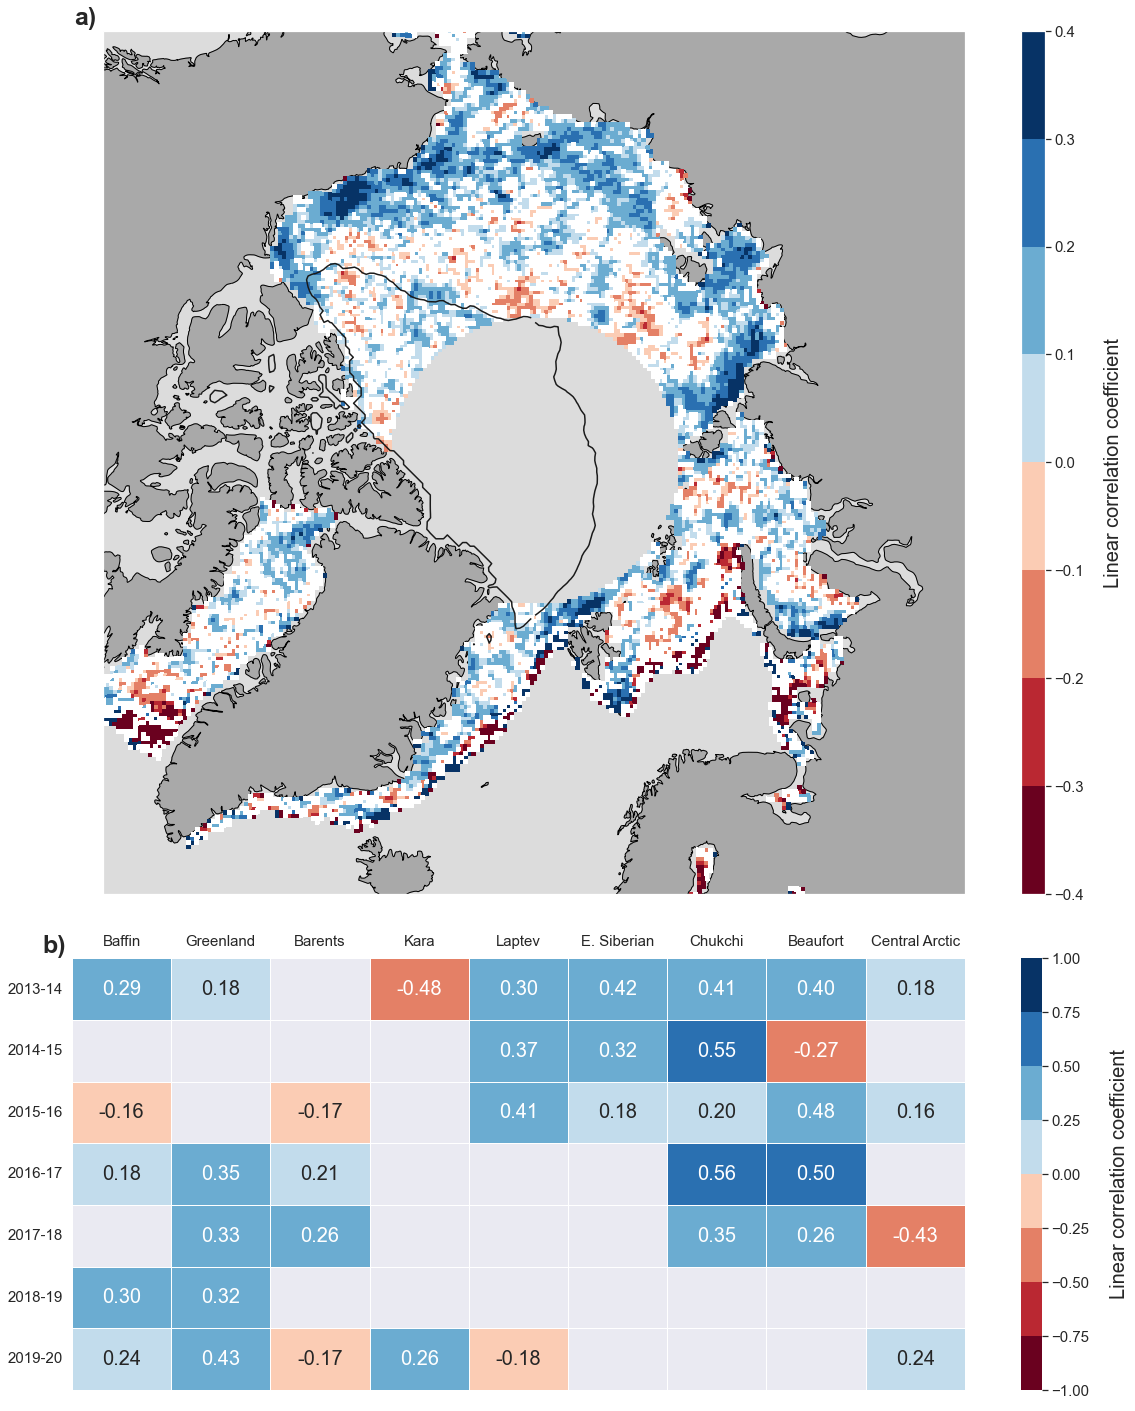

In [12]:
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')

rs_map[ps_map>0.05] = 1000
grey = rs_map.copy()
grey[grey <1000] = np.nan
rs_map[rs_map==1000] = np.nan
list_colors = ['#6A011F','#BA2832','#E48066','#FBCCB4','#C2DCEC','#6BACD1','#2A70B1','#073366']  

fig = plt.figure(figsize=(20,25))
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[2, 1],hspace=0.1)

ax1 = fig.add_subplot(spec[0],projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
cm = LinearSegmentedColormap.from_list('map', list_colors, N = 8)
p_map = ax1.pcolormesh(lons,lats,rs_map,cmap=cm,alpha=1.0, vmin=-0.4,vmax=0.4, transform=ccrs.PlateCarree())
ax1.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
ax1.set_title('a)', x = -0.02,y = 1,fontweight="bold", fontsize=25)
a = fig.colorbar(p_map,shrink=1,aspect=36)
a.set_label("Linear correlation coefficient",fontsize=20,labelpad=20)
a.ax.tick_params(labelsize=15)

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

cont_less = ax1.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5], # put 0.7 for 30%
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.5)

cont_Great = ax1.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.5)

mask = ps_table.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax2 = fig.add_subplot(spec[1])
ax2 = sns.heatmap(df, mask=mask, cmap=cm, annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons)
sns.set(rc={"figure.figsize":(20, 27)}) # to reset the background to grey
ax2.xaxis.tick_top()
ax2.set_xticklabels([])
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labeltop=True)
ax2.set_xlabel(' ')    
ax2.set_yticklabels(seasons,rotation = 0,fontsize=15)
ax2.set_xticklabels(regions,fontsize=15)
cbar = ax2.collections[0].colorbar
cbar.set_label("Linear correlation coefficient",fontsize = 20,labelpad=20)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('b)', x = -0.02,y = 1,fontsize = 25, fontweight="bold")

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/altika.png',bbox_inches = "tight")